In [1]:
import os

import pandas as pd
from tqdm import tqdm

from openhands.llm.fn_call_converter import (
    FunctionCallConversionError,
    convert_fncall_messages_to_non_fncall_messages,
    convert_from_multiple_tool_calls_to_single_tool_call_messages,
)

tqdm.pandas()

In [3]:
FOLDER_PATH = '/home/xingyaow/OpenHands-swe-train-fncall/evaluation/evaluation_outputs/outputs/datasets/2024-11-16-sonnet-4o-491instances'

df = pd.read_json(
    os.path.join(FOLDER_PATH, 'raw_outputs.jsonl'), lines=True, orient='records'
)
# df = df[df['resolved']]
len(df)

6055

In [2]:
FOLDER_PATH_ONPOLICY = '/home/xingyaow/OpenHands-swe-train-fncall/evaluation/evaluation_outputs/outputs/datasets/2024-12-08-self-iter1-868i-from-32b-1116-sonnet-4o-491i-32k'

df_onpolicy = pd.read_json(
    os.path.join(FOLDER_PATH_ONPOLICY, 'raw_outputs.jsonl'),
    lines=True,
    orient='records',
)
# df = df[df['resolved']]
len(df_onpolicy)

11920

In [4]:
def _contains_multiple_tool_calls(messages: list[dict]) -> bool:
    return any(
        message.get('tool_calls') and len(message['tool_calls']) > 1
        for message in messages
    )


df['contains_multiple_tool_calls'] = df['messages'].apply(_contains_multiple_tool_calls)
df_onpolicy['contains_multiple_tool_calls'] = df_onpolicy['messages'].apply(
    _contains_multiple_tool_calls
)
display(df.groupby(['contains_multiple_tool_calls'])['resolved'].sum())
display(df_onpolicy.groupby(['contains_multiple_tool_calls'])['resolved'].sum())

contains_multiple_tool_calls
False    411
True      80
Name: resolved, dtype: int64

contains_multiple_tool_calls
False    875
Name: resolved, dtype: int64

In [10]:
def _convert_messages(messages: list[dict], tools: list[dict]) -> list[dict]:
    try:
        return convert_fncall_messages_to_non_fncall_messages(
            messages, tools, add_in_context_learning_example=False
        )
    except FunctionCallConversionError:
        print(f'Failed to convert messages: {messages}\nTools: {tools}')
        return None


df['converted_messages'] = df.apply(
    lambda row: convert_from_multiple_tool_calls_to_single_tool_call_messages(
        row['messages'], ignore_final_tool_result=True
    ),
    axis=1,
)
df['nonfncall_messages'] = df.apply(
    lambda row: _convert_messages(row['converted_messages'], row['tools']), axis=1
)
df = df[~df['nonfncall_messages'].isna()]

df_onpolicy['nonfncall_messages'] = df_onpolicy['messages']  # is already non-fncall

In [13]:
def _convert_content(content) -> str:
    ret = ''
    if isinstance(content, list):
        for item in content:
            assert item['type'] == 'text', 'Only text is supported for now'
            ret += f'{item["text"]}\n'
    else:
        assert isinstance(content, str), 'Only str is supported for now'
        ret = content
    return ret


def convert_tool_call_to_string(tool_call: dict) -> str:
    """Convert tool call to content in string format."""
    if 'function' not in tool_call:
        raise ValueError("Tool call must contain 'function' key.")
    if 'id' not in tool_call:
        raise ValueError("Tool call must contain 'id' key.")
    if 'type' not in tool_call:
        raise ValueError("Tool call must contain 'type' key.")
    if tool_call['type'] != 'function':
        raise ValueError("Tool call type must be 'function'.")

    ret = f"<function={tool_call['function']['name']}>\n"
    try:
        args = json.loads(tool_call['function']['arguments'])
    except json.JSONDecodeError as e:
        raise ValueError(
            f"Failed to parse arguments as JSON. Arguments: {tool_call['function']['arguments']}"
        ) from e
    for param_name, param_value in args.items():
        is_multiline = isinstance(param_value, str) and '\n' in param_value
        ret += f'<parameter={param_name}>'
        if is_multiline:
            ret += '\n'
        ret += f'{param_value}'
        if is_multiline:
            ret += '\n'
        ret += '</parameter>\n'
    ret += '</function>'
    return ret


def format_traj(traj) -> str:
    output = ''
    system_message = None

    # Handle system message if present
    if traj[0]['role'] == 'system':
        system_message = traj[0]
        traj = traj[1:]
        content = _convert_content(system_message['content'])
        output += "*** System Message that describes the assistant's behavior ***\n"
        output += f'{content}\n'

    # Merge consecutive user messages first
    merged_traj = []
    current_messages = []

    for i, message in enumerate(traj):
        if message['role'] == 'user':
            current_messages.append(message)
        else:
            if current_messages:
                # Merge all accumulated user messages into one
                merged_content = '\n'.join(
                    _convert_content(msg['content']) for msg in current_messages
                )
                merged_traj.append({'role': 'user', 'content': merged_content})
                current_messages = []
            merged_traj.append(message)

    # Don't forget to handle any remaining user messages
    if current_messages:
        merged_content = '\n'.join(
            _convert_content(msg['content']) for msg in current_messages
        )
        merged_traj.append({'role': 'user', 'content': merged_content})

    # Now process the merged trajectory
    for i, message in enumerate(merged_traj):
        role, content = message['role'], message['content']
        content = _convert_content(content) if isinstance(content, list) else content
        turn_id = i // 2 + 1
        output += '-' * 100 + '\n'
        output += f'*** Turn {turn_id} - {role.upper() if role != "tool" else "TOOL EXECUTION RESULT"} ***\n'

        if role == 'user':
            output += f'{content}\n'
        elif role == 'tool':
            output += f'{content}\n'
        elif role == 'assistant':
            output += f'{content}\n'
            if (
                'tool_calls' in message
                and message['tool_calls'] is not None
                and len(message['tool_calls']) > 0
            ):
                for toolcall_id, tool_call in enumerate(message['tool_calls']):
                    output += f'### Tool Call {toolcall_id}\n'
                    output += f'{convert_tool_call_to_string(tool_call)}\n'
        else:
            raise ValueError(f'Unexpected role: {role}')

    output += '-' * 100 + '\n'
    return output


# print(format_traj(df['nonfncall_messages'].iloc[0]))
df['traj_str'] = df['nonfncall_messages'].progress_apply(lambda x: format_traj(x))
df_onpolicy['traj_str'] = df_onpolicy['nonfncall_messages'].progress_apply(
    lambda x: format_traj(x)
)

100%|██████████| 11920/11920 [00:01<00:00, 11004.21it/s]


In [14]:
def convert_traj_to_rm_conversations(traj_str: str, resolved: bool) -> list[dict]:
    SYSTEM_MESSAGE = """You are an expert judge evaluating AI assistant interactions. Your task is to determine if the assistant successfully resolved the user's request.

Key evaluation criteria:
1. Did the assistant complete the main task requested by the user?
2. Did the assistant handle all edge cases and requirements specified?
3. Were there any errors or issues in the final solution?
4. Did the assistant verify the solution works as intended?

Respond only with "<judgement>YES</judgement>" or "<judgement>NO</judgement>"."""
    USER_MESSAGE = (
        """Please evaluate the following interaction between an AI assistant and a user:

=== INTERACTION LOG ===
"""
        + traj_str
        + """
=== END INTERACTION ===

Based on the above interaction, did the assistant successfully resolve the user's initial request? Respond with YES or NO."""
    )
    return [
        {'role': 'system', 'content': SYSTEM_MESSAGE},
        {'role': 'user', 'content': USER_MESSAGE},
        {
            'role': 'assistant',
            'content': '<judgement>' + ('YES' if resolved else 'NO') + '</judgement>',
        },
    ]


df['rm_conv'] = df.progress_apply(
    lambda row: convert_traj_to_rm_conversations(row['traj_str'], row['resolved']),
    axis=1,
)
df_onpolicy['rm_conv'] = df_onpolicy.progress_apply(
    lambda row: convert_traj_to_rm_conversations(row['traj_str'], row['resolved']),
    axis=1,
)

100%|██████████| 11920/11920 [00:00<00:00, 14028.27it/s]


In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen2.5-7B-Instruct')

In [16]:
df['n_tokens'] = df['rm_conv'].progress_apply(
    lambda x: len(tokenizer.apply_chat_template(x))
)

100%|██████████| 6048/6048 [03:17<00:00, 30.55it/s] 


In [18]:
df_selected = df[df['n_tokens'] < 32768]

In [17]:
df_onpolicy['n_tokens'] = df_onpolicy['rm_conv'].progress_apply(
    lambda x: len(tokenizer.apply_chat_template(x))
)

100%|██████████| 11920/11920 [07:24<00:00, 26.80it/s]


In [19]:
df_onpolicy_selected = df_onpolicy[df_onpolicy['n_tokens'] < 32768]

In [20]:
df_selected[['rm_conv', 'resolved']]
# .to_json(os.path.join(FOLDER_PATH, 'rm_conv.jsonl'), lines=True, orient='records')

,rm_conv,resolved
0,"[{'role': 'system', 'content': 'You are an exp...",False
1,"[{'role': 'system', 'content': 'You are an exp...",False
2,"[{'role': 'system', 'content': 'You are an exp...",False
3,"[{'role': 'system', 'content': 'You are an exp...",False
4,"[{'role': 'system', 'content': 'You are an exp...",False
...,...,...
6047,"[{'role': 'system', 'content': 'You are an exp...",False
6048,"[{'role': 'system', 'content': 'You are an exp...",False
6049,"[{'role': 'system', 'content': 'You are an exp...",False
6050,"[{'role': 'system', 'content': 'You are an exp...",False


In [24]:
df_selected_combined = pd.concat([df_selected, df_onpolicy_selected])
df_selected_combined

,instance_id,test_result,resolved,messages_and_tools,messages,n_messages,tools,output_dir,n_tokens,contains_multiple_tool_calls,converted_messages,nonfncall_messages,traj_str,rm_conv,metadata,error,run_name
0,getmoto__moto-5321,"{'git_patch': '', 'report': {'empty_generation...",False,[[{'content': 'You are a helpful assistant tha...,[{'content': 'You are a helpful assistant that...,13,"[{'type': 'function', 'function': {'name': 'ex...",/home/xingyaow/OpenHands-swe-train-fncall/eval...,2418,False,[{'content': 'You are a helpful assistant that...,"[{'role': 'system', 'content': 'You are a help...",*** System Message that describes the assistan...,"[{'role': 'system', 'content': 'You are an exp...",NaN,NaN,NaN
1,getmoto__moto-5699,"{'git_patch': '', 'report': {'empty_generation...",False,[[{'content': 'You are a helpful assistant tha...,[{'content': 'You are a helpful assistant that...,9,"[{'type': 'function', 'function': {'name': 'ex...",/home/xingyaow/OpenHands-swe-train-fncall/eval...,2176,False,[{'content': 'You are a helpful assistant that...,"[{'role': 'system', 'content': 'You are a help...",*** System Message that describes the assistan...,"[{'role': 'system', 'content': 'You are an exp...",NaN,NaN,NaN
2,getmoto__moto-7495,"{'git_patch': '', 'report': {'empty_generation...",False,[[{'content': 'You are a helpful assistant tha...,[{'content': 'You are a helpful assistant that...,9,"[{'type': 'function', 'function': {'name': 'ex...",/home/xingyaow/OpenHands-swe-train-fncall/eval...,2186,False,[{'content': 'You are a helpful assistant that...,"[{'role': 'system', 'content': 'You are a help...",*** System Message that describes the assistan...,"[{'role': 'system', 'content': 'You are an exp...",NaN,NaN,NaN
3,getmoto__moto-5545,"{'git_patch': '', 'report': {'empty_generation...",False,[[{'content': 'You are a helpful assistant tha...,[{'content': 'You are a helpful assistant that...,9,"[{'type': 'function', 'function': {'name': 'ex...",/home/xingyaow/OpenHands-swe-train-fncall/eval...,2366,False,[{'content': 'You are a helpful assistant that...,"[{'role': 'system', 'content': 'You are a help...",*** System Message that describes the assistan...,"[{'role': 'system', 'content': 'You are an exp...",NaN,NaN,NaN
4,getmoto__moto-5020,"{'git_patch': '', 'report': {'empty_generation...",False,[[{'content': 'You are a helpful assistant tha...,[{'content': 'You are a helpful assistant that...,9,"[{'type': 'function', 'function': {'name': 'ex...",/home/xingyaow/OpenHands-swe-train-fncall/eval...,2507,False,[{'content': 'You are a helpful assistant that...,"[{'role': 'system', 'content': 'You are a help...",*** System Message that describes the assistan...,"[{'role': 'system', 'content': 'You are an exp...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11915,pandas-dev__pandas-50572,{'git_patch': 'diff --git a/pandas/core/dtypes...,False,NaN,"[{'role': 'system', 'content': 'You are OpenHa...",55,NaN,/home/xingyaow/OpenHands-swe-train-fncall/eval...,29124,False,"[{'role': 'system', 'content': 'You are OpenHa...","[{'role': 'system', 'content': 'You are OpenHa...",*** System Message that describes the assistan...,"[{'role': 'system', 'content': 'You are an exp...","{'agent_class': 'CodeActAgent', 'llm_config': ...",None,1116-sonnet-4o-491i-32k-qwen2p5-coder-32b-full...
11916,pandas-dev__pandas-48824,{'git_patch': 'diff --git a/pandas/core/arrays...,False,NaN,"[{'role': 'system', 'content': 'You are OpenHa...",59,NaN,/home/xingyaow/OpenHands-swe-train-fncall/eval...,31345,False,"[{'role': 'system', 'content': 'You are OpenHa...","[{'role': 'system', 'content': 'You are OpenHa...",*** System Message that describes the assistan...,"[{'role': 'system', 'content': 'You are an exp...","{'agent_class': 'CodeActAgent', 'llm_config': ...",None,1116-sonnet-4o-491i-32k-qwen2p5-coder-32b-full...
11917,pandas-dev__pandas-51274,{'git_patch': 'diff --git a/pandas/core/resamp...,False,NaN,"[{'role': 'system', 'content

In [ ]:
## CLAUDE+4O ONLY
# sample different resolved:non-resolved ratio
n_resolved = df_selected['resolved'].sum()
n_non_resolved = len(df_selected) - n_resolved

negative_multipliers = [0.5, 1, 2, 4]
for negative_multiplier in negative_multipliers:
    n_non_resolved_to_sample = int(n_resolved * negative_multiplier)
    df_non_resolved = df_selected[~df_selected['resolved']].sample(
        n=n_non_resolved_to_sample, random_state=42
    )
    cur_df = pd.concat([df_selected[df_selected['resolved']], df_non_resolved])
    print(
        f'Negative multiplier: {negative_multiplier}x: #resolved={n_resolved}, #non-resolved={n_non_resolved_to_sample}, #total={len(cur_df)}'
    )
    cur_df[['rm_conv', 'resolved']].rename(columns={'rm_conv': 'messages'}).to_json(
        os.path.join(
            FOLDER_PATH,
            f'rm_conv_32k_{n_resolved}i_negative_{negative_multiplier}x_{n_non_resolved_to_sample}i.jsonl',
        ),
        lines=True,
        orient='records',
    )

In [28]:
## ONLY ONPOLICY
# sample different resolved:non-resolved ratio
n_resolved = df_onpolicy_selected['resolved'].sum()
n_non_resolved = len(df_onpolicy_selected) - n_resolved

negative_multipliers = [0.5, 1, 2, 4]
for negative_multiplier in negative_multipliers:
    n_non_resolved_to_sample = int(n_resolved * negative_multiplier)
    df_non_resolved = df_onpolicy_selected[~df_onpolicy_selected['resolved']].sample(
        n=n_non_resolved_to_sample, random_state=42
    )
    cur_df = pd.concat(
        [df_onpolicy_selected[df_onpolicy_selected['resolved']], df_non_resolved]
    )
    print(
        f'Negative multiplier: {negative_multiplier}x: #resolved={n_resolved}, #non-resolved={n_non_resolved_to_sample}, #total={len(cur_df)}'
    )
    cur_df[['rm_conv', 'resolved']].rename(columns={'rm_conv': 'messages'}).to_json(
        os.path.join(
            FOLDER_PATH,
            f'rm_conv_32k_onpolicy_{n_resolved}i_negative_{negative_multiplier}x_{n_non_resolved_to_sample}i.jsonl',
        ),
        lines=True,
        orient='records',
    )

Negative multiplier: 0.5x: #resolved=875, #non-resolved=437, #total=1312
Negative multiplier: 1x: #resolved=875, #non-resolved=875, #total=1750
Negative multiplier: 2x: #resolved=875, #non-resolved=1750, #total=2625
Negative multiplier: 4x: #resolved=875, #non-resolved=3500, #total=4375


In [27]:
# COMBINED
# sample different resolved:non-resolved ratio
_n_resolved = df_selected_combined['resolved'].sum()
_n_non_resolved = len(df_selected_combined) - _n_resolved

negative_multipliers = [0.5, 1, 2, 4]
for negative_multiplier in negative_multipliers:
    _n_non_resolved_to_sample = int(_n_resolved * negative_multiplier)
    _df_non_resolved = df_selected_combined[~df_selected_combined['resolved']].sample(
        n=_n_non_resolved_to_sample, random_state=42
    )
    _cur_df = pd.concat(
        [df_selected_combined[df_selected_combined['resolved']], _df_non_resolved]
    )
    print(
        f'Negative multiplier: {negative_multiplier}x: #resolved={_n_resolved}, #non-resolved={_n_non_resolved_to_sample}, #total={len(_cur_df)}'
    )
    _cur_df[['rm_conv', 'resolved']].rename(columns={'rm_conv': 'messages'}).to_json(
        os.path.join(
            FOLDER_PATH,
            f'rm_conv_32k_claude+4o+onpolicy_{_n_resolved}i_negative_{negative_multiplier}x_{_n_non_resolved_to_sample}i.jsonl',
        ),
        lines=True,
        orient='records',
    )

Negative multiplier: 0.5x: #resolved=1318, #non-resolved=659, #total=1977
Negative multiplier: 1x: #resolved=1318, #non-resolved=1318, #total=2636
Negative multiplier: 2x: #resolved=1318, #non-resolved=2636, #total=3954
Negative multiplier: 4x: #resolved=1318, #non-resolved=5272, #total=6590


In [ ]:
# # df[df['resolved']][['nonfncall_messages', 'tools']].rename(columns={'nonfncall_messages': 'messages'}).to_json("/home/xingyaow/OpenHands-swe-train-fncall/evaluation/evaluation_outputs/outputs/swe-train__swe-train-dev-v1-lite-train.v2.success/CodeActAgent/datasets/2024-11-03-gpt-4o-sampled/converted_for_oss.jsonl", lines=True, orient='records')
# # df[df['resolved']][['nonfncall_messages', 'tools']].rename(columns={'nonfncall_messages': 'messages'}).to_json("/home/xingyaow/OpenHands-swe-train-fncall/evaluation/evaluation_outputs/outputs/swe-train__swe-train-dev-v1-lite-train.v2.success/CodeActAgent/datasets/2024-11-14-sonnet3.5-sampled/converted_for_oss.jsonl", lines=True, orient='records')
# df[df['resolved']][['nonfncall_messages', 'tools']].rename(columns={'nonfncall_messages': 'messages'}).to_json(os.path.join(FOLDER_PATH, 'converted_for_oss.jsonl'), lines=True, orient='records')

In [27]:
# df['n_tokens'] = df['rm_conv'].progress_apply(lambda x: len(tokenizer.apply_chat_template(x)))

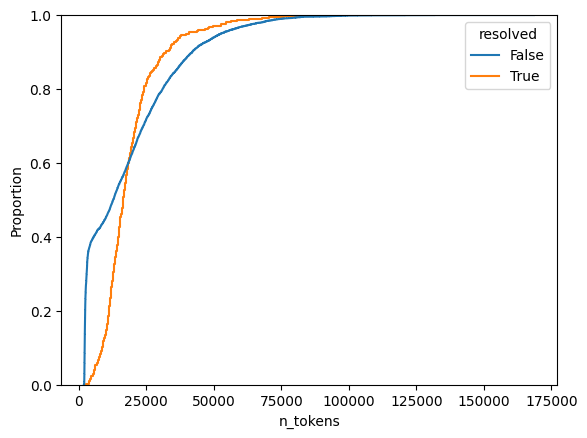

In [10]:
# plot ecdf of n_tokens & n_messages
import matplotlib.pyplot as plt
import seaborn as sns

sns.ecdfplot(x='n_tokens', data=df, hue='resolved')
plt.show()

In [14]:
df[['nonfncall_messages', 'tools', 'resolved']].rename(
    columns={'nonfncall_messages': 'messages'}
).to_json(
    os.path.join(FOLDER_PATH, 'complete.converted_for_oss.jsonl'),
    lines=True,
    orient='records',
)